In [1]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

### Read data

In [2]:
data = pd.read_csv('../Data/ver1.csv', index_col=0)
data.drop(["index"], inplace = True, axis=1)

In [3]:
data

,Text,oh_label
0,Im 12 and i can understand it perfectly. You s...,1.0
1,"#mkr Boy, @FourinHandyou sure know how to dish...",0.0
2,Fuck you all. This site is full of stuck up ...,1.0
3,"` ::I don't disagree with your point, except...",0.0
4,"do i look like i give a fuck, u are all sad ...",1.0
...,...,...
99995,` == d15b8 - just you leave it alone == ``co...,0.0
99996,":Thanks for the feedback, and I'm very glad t...",0.0
99997,==Fast and Furious 7== Please do your resear...,0.0
99998,@KWiebs31 ABLOO BLOO BLOO,0.0


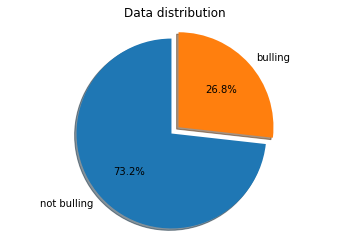

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(data["oh_label"].value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [5]:
data.columns = ['Text', 'oh_label']

In [6]:
data.head()

,Text,oh_label
0,Im 12 and i can understand it perfectly. You s...,1.0
1,"#mkr Boy, @FourinHandyou sure know how to dish...",0.0
2,Fuck you all. This site is full of stuck up ...,1.0
3,"` ::I don't disagree with your point, except...",0.0
4,"do i look like i give a fuck, u are all sad ...",1.0


In [7]:
data.shape 

(100000, 2)

In [8]:
data.shape

(100000, 2)

In [9]:
# 1 it's represent negative and 0 for positive
pos = []
neg = []
for l in data.oh_label:
    if l == 0:
        pos.append(1)
        neg.append(0)
    elif l == 1:
        pos.append(0)
        neg.append(1)

In [10]:
data['Pos']= pos
data['Neg']= neg

In [11]:
data.head()

,Text,oh_label,Pos,Neg
0,Im 12 and i can understand it perfectly. You s...,1.0,0,1
1,"#mkr Boy, @FourinHandyou sure know how to dish...",0.0,1,0
2,Fuck you all. This site is full of stuck up ...,1.0,0,1
3,"` ::I don't disagree with your point, except...",0.0,1,0
4,"do i look like i give a fuck, u are all sad ...",1.0,0,1


### Clean data

### string punctation
#### '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

### Word Tokenization

In [6]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]
# tokens

In [7]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens] 

In [8]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

#### Examples for stop words: 
'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your'
##### The definition of stop words it's words that not add to the meaning of the sentence 

In [9]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

In [10]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [11]:
result = [' '.join(sen) for sen in filtered_words]

In [12]:
data['Text_Final'] = result

In [13]:
data['tokens'] = filtered_words

In [14]:
data = data[['Text_Final', 'tokens', 'oh_label', 'Pos', 'Neg']]

KeyError: "['Pos', 'Neg'] not in index"

In [22]:
data[:4]

,Text_Final,tokens,oh_label,Pos,Neg
0,im 12 understand perfectly learn english inste...,"[im, 12, understand, perfectly, learn, english...",1.0,0,1
1,mkr boy fourinhandyou sure know dish insult sa...,"[mkr, boy, fourinhandyou, sure, know, dish, in...",0.0,1,0
2,fuck site full stuck cunts unknown reason thin...,"[fuck, site, full, stuck, cunts, unknown, reas...",1.0,0,1
3,dont disagree point except im exactly trying a...,"[dont, disagree, point, except, im, exactly, t...",0.0,1,0


### Split data into test and train

In [16]:
data_train, data_test = train_test_split(data, test_size=0.30, random_state=42)
data_test, data_test_final = train_test_split(data_test, test_size=0.50, random_state=42)

In [17]:
x_neg_weight = data_train[data_train["oh_label"]==1].shape
x_pos_weight = data_train[data_train["oh_label"]==0].shape
x_neg_weight[0]/x_pos_weight[0]

0.3686309779845931

In [18]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

2290656 words total, with a vocabulary size of 131067
Max sentence length is 2481


In [19]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

483005 words total, with a vocabulary size of 50477
Max sentence length is 2494


### Load Google News Word2Vec model

In [28]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [29]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

### Get Embeddings

In [30]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [22]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

### Tokenize and Pad sequences

In [20]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 130531 unique tokens.


In [23]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_cnn_data.shape

(70000, 50)

In [24]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

NameError: name 'word2vec' is not defined

In [28]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_cnn_data[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     3,   255,    50,  1219,
          41,     1,   348,    52,   697,  8499,    19,   561,   764,
         808,     5,   157,   734,  1050,  2729,   601,  1042,  2401,
         692,  3201,     5, 22842,  4007])

### Define CNN

In [36]:
label_names = ['Pos', 'Neg']

In [37]:
y_train = data_train[label_names].values

In [38]:
x_train = train_cnn_data
y_tr = y_train

In [39]:
from keras.layers import Conv1D,MaxPool1D,Flatten
import tensorflow as tf

In [40]:
def cnn(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    conv1d = Conv1D(20,7,strides=1, use_bias=True,padding="valid")(embedded_sequences)
    max_pool = MaxPool1D(pool_size=3)(conv1d)
    flattened = Flatten()(max_pool)
    x1 = Dense(128, activation='relu')(flattened)
    x1 = Dropout(0.2)(x1)
    x2 = Dense(64, activation='relu')(x1)
    preds = Dense(labels_index, activation='sigmoid')(x2)
    model = Model(sequence_input, preds)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
    model.summary()
    return model

In [41]:
model = cnn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           39159600  
_________________________________________________________________
conv1d (Conv1D)              (None, 44, 20)            42020     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 280)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               35968     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

### Train CNN

In [42]:
num_epochs = 100
batch_size = 150

In [43]:
len(list(label_names))

2

In [44]:
y_tr.shape

(70000, 2)

In [45]:
weights = {0: (x_neg_weight[0]/(x_pos_weight[0]+x_neg_weight[0])),1: (x_pos_weight[0]/(x_pos_weight[0]+x_neg_weight[0]))}

In [59]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
hist = model.fit(x_train, y_tr, epochs=10, validation_split=0.1, shuffle=True,class_weight=weights, batch_size=batch_size,use_multiprocessing=True,workers=8)
hist

Epoch 1/10
420/420 [==============================] - 16s 37ms/step - loss: 0.1834 - accuracy: 0.7719 - recall_1: 0.7708 - precision_1: 0.7715 - val_loss: 0.4231 - val_accuracy: 0.8031 - val_recall_1: 0.8044 - val_precision_1: 0.8018
Epoch 2/10
420/420 [==============================] - 16s 38ms/step - loss: 0.1553 - accuracy: 0.8158 - recall_1: 0.8166 - precision_1: 0.8148 - val_loss: 0.4597 - val_accuracy: 0.7669 - val_recall_1: 0.7660 - val_precision_1: 0.7668
Epoch 3/10
420/420 [==============================] - 15s 35ms/step - loss: 0.1432 - accuracy: 0.8257 - recall_1: 0.8265 - precision_1: 0.8251 - val_loss: 0.4302 - val_accuracy: 0.7807 - val_recall_1: 0.7813 - val_precision_1: 0.7806
Epoch 4/10
420/420 [==============================] - 16s 38ms/step - loss: 0.1302 - accuracy: 0.8354 - recall_1: 0.8350 - precision_1: 0.8353 - val_loss: 0.3914 - val_accuracy: 0.8066 - val_recall_1: 0.8060 - val_precision_1: 0.8065
Epoch 5/10
420/420 [==============================] - 15s 37ms/s

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
predictions = model.predict(test_cnn_data)
prediction_labels=[]
labels = [0, 1]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])
print(classification_report(data_test.oh_label,prediction_labels))

In [46]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
hist2 = model.fit(x_train, y_tr, epochs=100, validation_split=0.1, shuffle=True,class_weight=weights, batch_size=batch_size,use_multiprocessing=True,workers=8,callbacks=[callback])
hist2

Epoch 1/100
420/420 [==============================] - 23s 46ms/step - loss: 0.1838 - accuracy: 0.7656 - recall: 0.7663 - precision: 0.7636 - val_loss: 0.3878 - val_accuracy: 0.8243 - val_recall: 0.8230 - val_precision: 0.8246
Epoch 2/100
420/420 [==============================] - 18s 43ms/step - loss: 0.1564 - accuracy: 0.8110 - recall: 0.8100 - precision: 0.8108 - val_loss: 0.4648 - val_accuracy: 0.7816 - val_recall: 0.7793 - val_precision: 0.7814
Epoch 3/100
420/420 [==============================] - 18s 43ms/step - loss: 0.1437 - accuracy: 0.8238 - recall: 0.8230 - precision: 0.8237 - val_loss: 0.4163 - val_accuracy: 0.8023 - val_recall: 0.8040 - val_precision: 0.8016
Epoch 4/100
420/420 [==============================] - 19s 44ms/step - loss: 0.1314 - accuracy: 0.8354 - recall: 0.8355 - precision: 0.8357 - val_loss: 0.3865 - val_accuracy: 0.8127 - val_recall: 0.8126 - val_precision: 0.8132
Epoch 5/100
420/420 [==============================] - 18s 43ms/step - loss: 0.1192 - accura

In [48]:
from sklearn.metrics import confusion_matrix,classification_report
predictions = model.predict(test_cnn_data)
prediction_labels=[]
labels = [0, 1]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])
print(classification_report(data_test.oh_label,prediction_labels))

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88     11039
         1.0       0.66      0.78      0.72      3961

    accuracy                           0.84     15000
   macro avg       0.79      0.82      0.80     15000
weighted avg       0.85      0.84      0.84     15000



In [49]:
embeddings, max_sequence_length, num_words, embedding_dim, labels_index = train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names))
embedding_layer = Embedding(num_words,
                        embedding_dim,
                        weights=[embeddings],
                        input_length=max_sequence_length,
                        trainable=False)

sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

conv1d = Conv1D(20,7,strides=1, use_bias=True,padding="valid")(embedded_sequences)
max_pool = MaxPool1D(pool_size=3)(conv1d)
flattened = Flatten()(max_pool)
x1 = Dropout(0.5)(flattened)
x2 = Dense(64, activation='relu')(x1)
x2 = Dropout(0.2)(x2)
preds = Dense(labels_index, activation='sigmoid')(x2)
model = Model(sequence_input, preds)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           39159600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 20)            42020     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 20)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 280)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 280)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1798

In [50]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
hist3 = model.fit(x_train, y_tr, epochs=1000, validation_split=0.1, shuffle=True,class_weight=weights, batch_size=batch_size,use_multiprocessing=True,workers=8,callbacks=[callback])
hist3

Epoch 1/1000
420/420 [==============================] - 19s 43ms/step - loss: 0.1965 - accuracy: 0.7478 - recall_1: 0.7462 - precision_1: 0.7458 - val_loss: 0.4094 - val_accuracy: 0.8190 - val_recall_1: 0.8157 - val_precision_1: 0.8199
Epoch 2/1000
420/420 [==============================] - 17s 40ms/step - loss: 0.1709 - accuracy: 0.7977 - recall_1: 0.7953 - precision_1: 0.7982 - val_loss: 0.4363 - val_accuracy: 0.7903 - val_recall_1: 0.7894 - val_precision_1: 0.7917
Epoch 3/1000
420/420 [==============================] - 17s 40ms/step - loss: 0.1646 - accuracy: 0.8043 - recall_1: 0.8011 - precision_1: 0.8057 - val_loss: 0.3857 - val_accuracy: 0.8286 - val_recall_1: 0.8274 - val_precision_1: 0.8294
Epoch 4/1000
420/420 [==============================] - 17s 40ms/step - loss: 0.1588 - accuracy: 0.8083 - recall_1: 0.8051 - precision_1: 0.8101 - val_loss: 0.3881 - val_accuracy: 0.8291 - val_recall_1: 0.8263 - val_precision_1: 0.8295
Epoch 5/1000
420/420 [==============================] - 

### Test CNN

In [ ]:
predictions = model.predict(test_cnn_data)
predictions

In [ ]:
labels = [0, 1]

In [ ]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(data_test.oh_label==prediction_labels)/len(prediction_labels)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data_test.oh_label,prediction_labels)

### My checks 

In [219]:
x = np.array(["i not love hate you"])  # correct 
x = np.array(["I stop to hate this boy"])  # mistake 
x = np.array(["I liked the book, especially the ending."])  # correct 
test_sequences = tokenizer.texts_to_sequences(x.tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
predictions = model.predict(test_data, batch_size=1, verbose=1)
predictions      # [pos, neg]
# test_sequences

1/1 [==============================] - 0s 44ms/step


array([[0.9001459 , 0.10048452]], dtype=float32)